# kNN Time Series

I was interested in creating my own time series algorithm from scratch and so chose the kNN time series approach as it is relatively straight forward. I was motivated by this [Data Skeptic podcast](https://www.youtube.com/watch?v=_p8UXoP0yxA&ab_channel=DataSkeptic) and you can learn more about kNN in time series analysis there.

## Obtaining and cleaning data

I will use the function I [developed previously](./wrangle.html) to import NVDA stock price data and limit the date to April 29th, 2022 for reproducibility and to compare RMSE with the other models in this [report](./nvda_analysis.html).

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from math import exp, ceil

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from python.functions import get_stonk

stonk = get_stonk("nvda")
nvda = stonk["data"]
nvda = nvda["Close"].interpolate(method='time')
nvda = nvda[:"2022-04-29"]
nvda

Date
1999-01-22      0.376709
1999-01-25      0.416174
1999-01-26      0.383885
1999-01-27      0.382689
1999-01-28      0.381494
                 ...    
2022-04-25    199.020004
2022-04-26    187.880005
2022-04-27    184.149994
2022-04-28    197.820007
2022-04-29    185.470001
Name: Close, Length: 5858, dtype: float64

## Split the data

I will now split the data into train/validate/test sets in a 70/20/10 percentage split respectively.

In [11]:
train = nvda[:round(len(nvda)*0.7)]
validate = nvda[round(len(nvda)*0.7)+1:round(len(nvda)*0.9)]
test = nvda[round(len(nvda)*0.9)+1:]
print(f"Train: {len(train)}\nValidate: {len(validate)}\nTest: {len(test)}")

Train: 4101
Validate: 1170
Test: 585


## The kNN time series algorithm

The basic idea of this algorithm is to compare a target window of time series data to slices of windows from the training data using a distance metric. You select the top k slices that look the most like the target and then build the prediction by extending out each slice's window a desired amount and taking the mean of these.

This algorithm requires 3 parameters, span, offset, and k. Span represents the size of the target window and each slice. Offset is the amount we will slide our window forward each time we take a new slice. k is the number of top neighbors we will take when building our prediction.

You must also give the algorithm how many time steps of predictions you would like to compute.

I will min/max normalize my target window and each slice so that they are directly comparable. To compute distance between the target window and each slice I will actually use the mean squared error as this is faster to compute and achieves the same effect as euclidean distance. In order to give more recent observations more weight I will compute the weighted MSE using a vector of weights that increases exponentially.

Min/max normalized target window:
[0.52441638 0.52819129 0.55460441 0.45649725 0.47913696 0.53951301
 0.47159238 0.56060548 0.49621274 0.51893779 0.46590944 0.6704558
 0.51136252 0.60606006 0.76893947 0.65151389 0.67424043 0.82197081
 0.77651324 0.69696922 0.70833137 0.81060567 0.91666536 0.7727286
 0.90530246 1.         0.71211975 0.59469642 0.07954402 0.05303059
 0.20833324 0.24242193 0.03787707 0.06818262 0.08712003 0.31818206
 0.39015231 0.45075741 0.64393788 0.73106016 0.65151389 0.57954589
 0.68181794 0.6287866  0.51893779 0.47727159 0.46590944 0.56060548
 0.5265138  0.45454804 0.51893779 0.56060548 0.49621274 0.51893779
 0.72727177 0.67424043 0.45454804 0.48105922 0.6287866  0.        ]


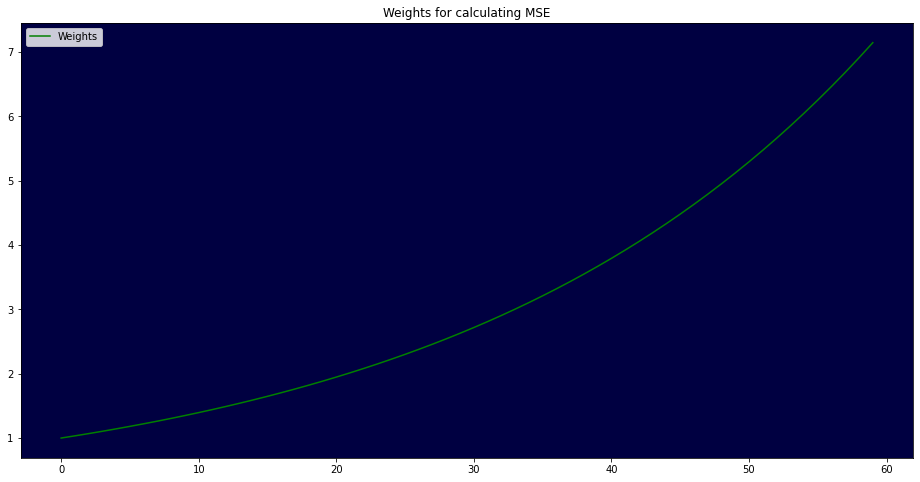

In [12]:
span = 60
offset = 5
k = 5

data = train
min_max_scaler = preprocessing.MinMaxScaler()

# Slice out target
target = data[-span:]
# Min/max normalize
x = target.values.reshape(-1,1)
x_scaled = min_max_scaler.fit_transform(x).reshape(span,)
norm = pd.Series(x_scaled, index=target.index, name="norm")
# Add index position from original data
index = pd.Series(np.arange(len(target)-span, len(target), 1), index=target.index, name="index")
target = pd.concat([target, norm, index], axis=1)

# For weighted MSE
y_step = 2/span
y_weights = np.arange(0, 2, y_step)
y_weights = [exp(y) for y in y_weights]
print(f"Min/max normalized target window:\n{target['norm'].values}")
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor("#000041")
plt.plot(y_weights, color="green", label="Weights")
plt.legend()
plt.title(f"Weights for calculating MSE")
plt.show()

Great, it looks like we have an appropriate vector of weights and target window.

Now lets slice out windows, normalize them, and then calculate distance to the target. Finally, we will take the top k sliced windows according to their weight MSE.

In [13]:
# Create dict of neighbors
# Keys are RMSE and values are df containing window and index
end = len(data)-((len(data)-span)%offset)-span*2+1
vecs = dict()
# Create window vectors
for i in range(0, end, offset):
    # Slice out window
    window = data[i:i+span]
    # Min/max normalize
    x = window.values.reshape(-1,1)
    x_scaled = min_max_scaler.fit_transform(x).reshape(span,)
    window = pd.Series(x_scaled, index=window.index, name="Close")
    
    # Add index position from original data
    index = pd.Series(np.arange(i, i+span, 1), index=window.index, name="index")
    df = pd.concat([window, index], axis=1)
    
    # Calc MSE
    # mse = mean_squared_error(df["Close"], target["norm"])
    # Calc weighted MSE
    mse = np.average((df["Close"].values-target["norm"].values)**2, axis=0, weights=y_weights)
    # Assign keys as RMSE and values as window data
    vecs[mse] = df

top_k = sorted(vecs.keys())[:k]
top_k

[0.05121726202647074,
 0.051778950226262,
 0.055955817262818265,
 0.05616113070364114,
 0.057374513862897415]

From the output above we can see the top 5 windows' weighted MSEs. 

Let's plot them against the target to see how they align.

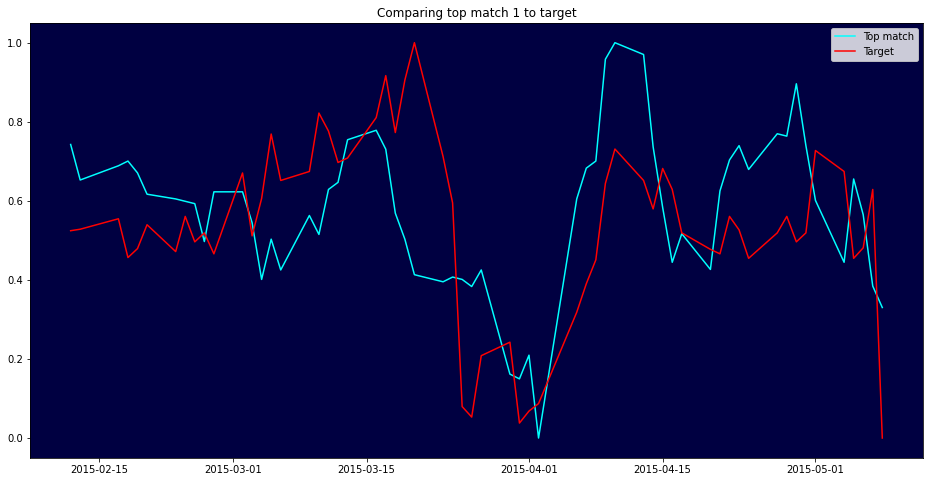

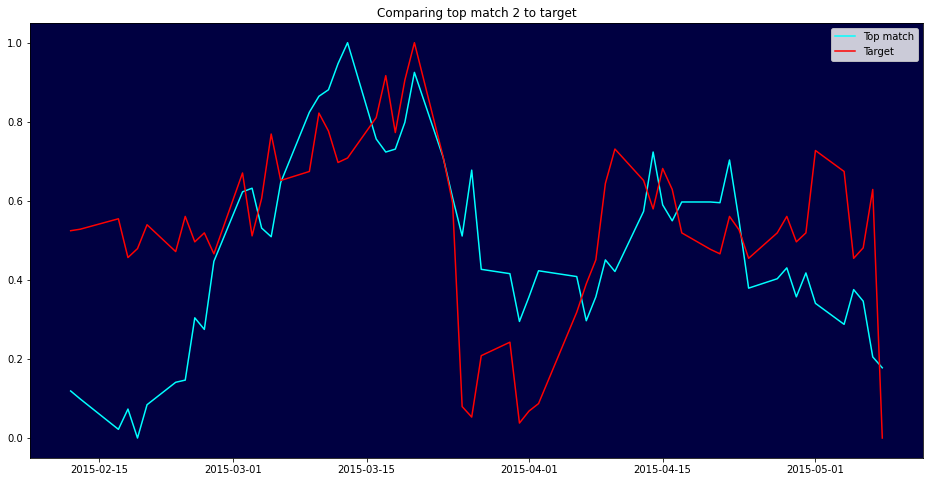

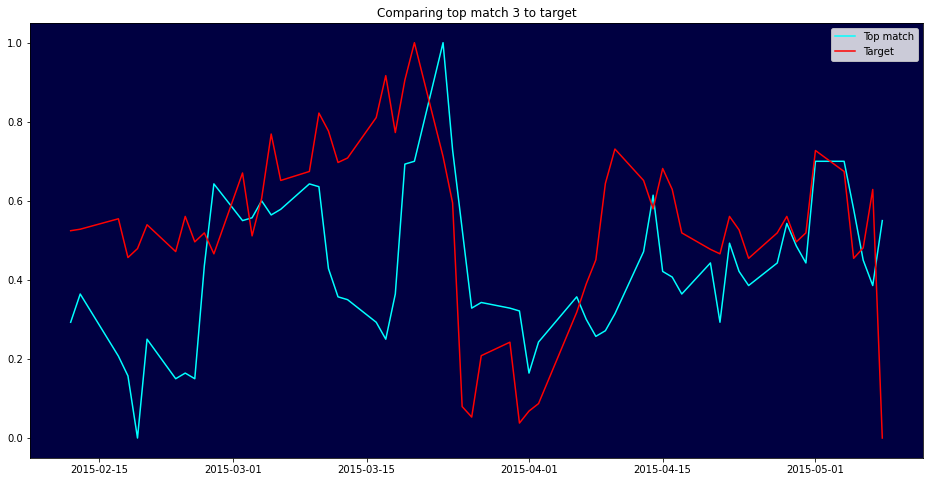

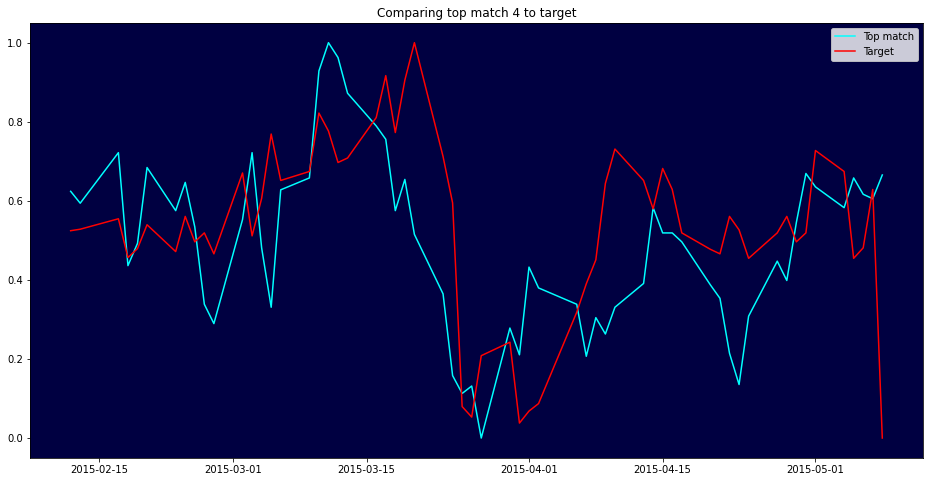

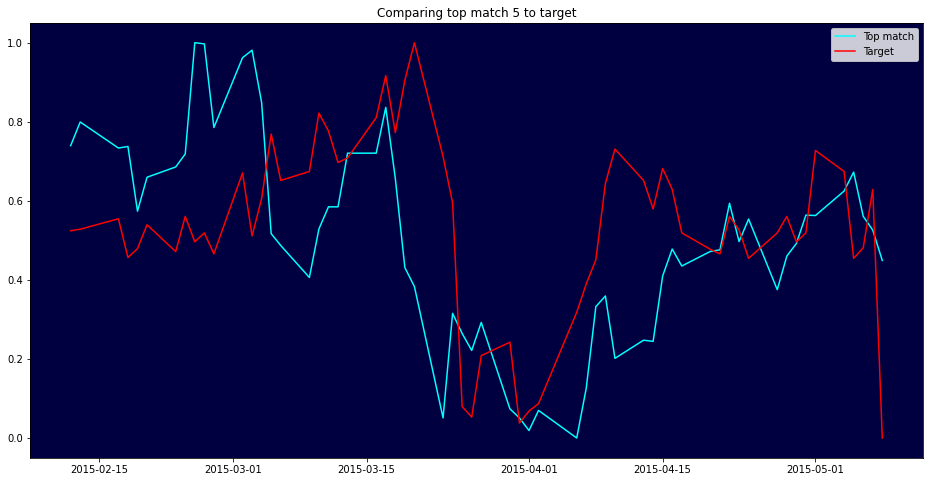

In [14]:
for i in range(5):
    top_match = vecs[top_k[i]]
    df = pd.concat([target["norm"].rename("target"), top_match.set_index(target.index)], axis=1)

    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_facecolor("#000041")
    plt.plot(df["Close"], color="cyan", label="Top match")
    plt.plot(df["target"], color="red", label="Target")
    plt.legend()
    plt.title(f"Comparing top match {i+1} to target")
    plt.show()

Great, it looks like all five of these compare nicely to the target window.

Now lets compute our prediction from them.

In [15]:
n_preds = 10
preds = pd.DataFrame()
for i in range(k):
    index = vecs[top_k[i]]["index"]
    win_raw = data[index[0]:index[-1]]
    max_raw = max(win_raw)
    min_raw = min(win_raw)
    x = data[index[-1]+1:index[-1]+1+n_preds]
    n_pred_norm = (x - min_raw) / (max_raw - min_raw)
    preds[f"k_{i}"] = n_pred_norm.to_numpy()

preds["mean"] = preds.mean(axis=1)
t_max = max(target["Close"])
t_min = min(target["Close"])
preds["predictions"] = (preds["mean"] * (t_max-t_min))+t_min
preds

,k_0,k_1,k_2,k_3,k_4,mean,predictions
0,0.342187,0.120880,0.392858,0.875941,0.348303,0.416034,5.291206
1,0.384331,0.091576,0.497066,1.000000,0.322355,0.459065,5.318618
2,0.510760,0.172162,0.662358,0.954888,0.047904,0.469614,5.325338
3,0.546881,0.084250,0.705478,0.969927,-0.261477,0.409012,5.286733
4,0.733516,0.247254,0.741413,1.184212,-0.204591,0.540361,5.370405
5,0.787700,0.344322,0.705478,1.180452,-0.062875,0.591016,5.402673
6,0.811781,0.390110,0.806092,1.030077,-0.122755,0.583061,5.397606
7,0.721476,0.342491,0.798906,1.124062,-0.246507,0.548086,5.375326
8,0.775659,0.311354,0.777342,1.157896,-0.066866,0.591077,5.402712
9,0.902088,0.327838,0.820465,1.131581,-0.278443,0.580706,5.396106


From the output above we can see the top 5 windows next 10 values, their mean, and finally the algorithm's prediction.

Let's compile all this code into one function.

In [16]:
def knn_ts(data, span, offset, k, n_preds, weighted_mse=True):
    min_max_scaler = preprocessing.MinMaxScaler()

    # Slice out target
    target = data[-span:]
    # Min/max normalize
    x = target.values.reshape(-1,1)
    x_scaled = min_max_scaler.fit_transform(x).reshape(span,)
    norm = pd.Series(x_scaled, index=target.index, name="norm")
    # Add index position from original data
    index = pd.Series(np.arange(len(target)-span, len(target), 1), index=target.index, name="index")
    target = pd.concat([target, norm, index], axis=1)
    
    # For weighted MSE
    y_step = 1/span
    y_weights = np.arange(1, 2, y_step)
    y_weights = [exp(y) for y in y_weights]

    # Create dict of neighbors
    # Keys are RMSE and values are df containing window and index
    end = len(data)-((len(data)-span)%offset)-span*2+1
    vecs = dict()
    # Create window vectors
    for i in range(0, end, offset):
        # Slice out window
        window = data[i:i+span]
        # Min/max normalize
        x = window.values.reshape(-1,1)
        x_scaled = min_max_scaler.fit_transform(x).reshape(span,)
        window = pd.Series(x_scaled, index=window.index, name="Close")
        
        # Add index position from original data
        index = pd.Series(np.arange(i, i+span, 1), index=window.index, name="index")
        df = pd.concat([window, index], axis=1)
        
        if weighted_mse:
            # Calc weighted MSE
            mse = np.average((df["Close"].values-target["norm"].values)**2, axis=0, weights=y_weights)
        else:
            # Calc sum squared error (SSE)
            mse = mean_squared_error(df["Close"], target["norm"])

        # Assign keys as RMSE and values as window data
        vecs[mse] = df

    top_k = sorted(vecs.keys())[:k]

    preds = pd.DataFrame()
    for i in range(k):
        index = vecs[top_k[i]]["index"]
        win_raw = data[index[0]:index[-1]]
        max_raw = max(win_raw)
        min_raw = min(win_raw)
        x = data[index[-1]+1:index[-1]+1+n_preds]
        n_pred_norm = (x - min_raw) / (max_raw - min_raw)
        preds[f"k_{i}"] = n_pred_norm.to_numpy()

    preds["mean"] = preds.mean(axis=1)
    t_max = max(target["Close"])
    t_min = min(target["Close"])
    preds["predictions"] = (preds["mean"] * (t_max-t_min))+t_min

    return preds

Now that we have a function let's use it by predicting ten days out on the training set and compare those predictions to the first ten values of the validation set.

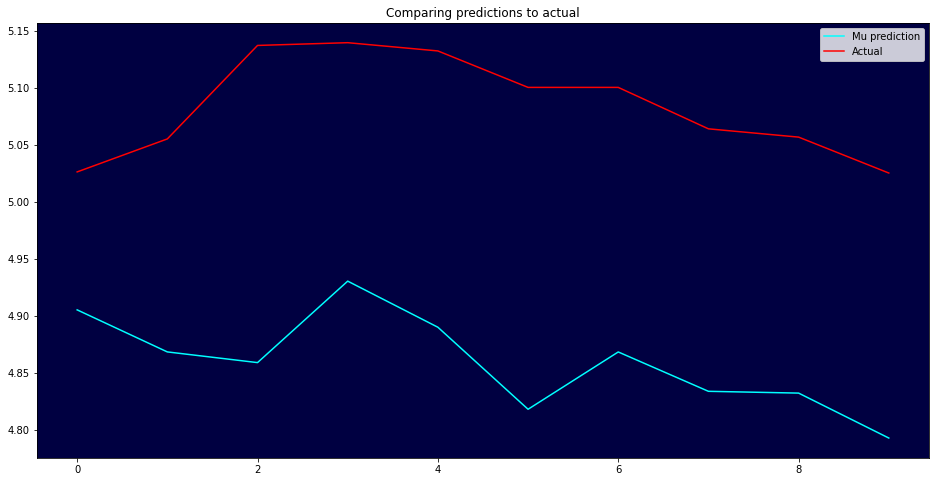

In [17]:
n_preds = 10
pred = knn_ts(train, 20, 8, 4, n_preds)
val = validate[:] #Copy data without referencing original data
val.reset_index(inplace=True, drop=True)
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor("#000041")
plt.plot(pred["predictions"], color="cyan", label="Mu prediction")
plt.plot(val[:n_preds], color="red", label="Actual")
plt.legend()
plt.title(f"Comparing predictions to actual")
plt.show()

That's not a bad result. Now let's try to find more optimal input parameters by performing a grid search on them, selecting the best params based on the lowest RMSE after performing a 20 step walk forward validation into the validate set. I will predict five days ahead as that is the ultimate goal of my final project.

In [18]:
n = 5
end = 20
grid_search = dict()
for s in range(5, 26, 5):
    for o in range(2, 8):
        for k in range(2, 5):
            preds = list()
            for i in range(end):
                data = pd.concat([train, validate[:i]])
                pred = knn_ts(data, s, o, k, n)
                preds.append(pred["predictions"][n-1])

            preds = pd.Series(preds, index=validate.index[n:end+n])
            rmse = mean_squared_error(preds, validate[n:end+n], squared=False)
            grid_search[rmse] = {"preds": preds, "params": (s,o,k)}

best_pred_rmse = sorted(grid_search.keys())[:1][0]
best_pred_obj = grid_search[best_pred_rmse]
params = best_pred_obj["params"]
best_pred = best_pred_obj["preds"]
print(f"Best params: {params}")

Best params: (25, 7, 3)


Let's graph the five day ahead predictions generated from the grid search using the best params we just found.

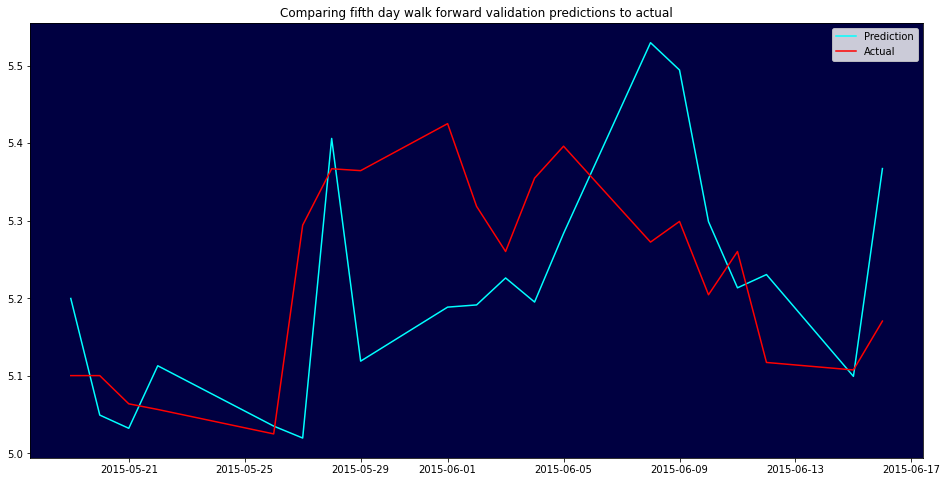

In [19]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor("#000041")
plt.plot(best_pred, color="cyan", label="Prediction")
plt.plot(validate[n:n+end], color="red", label="Actual")
plt.legend()
plt.title(f"Comparing fifth day walk forward validation predictions to actual")
plt.show()

These params result in a decent average of the actual price.

Now let's perform the exhaustive walk forward validation using these optimal parameters on the validation set, calculate the RMSE, and visualize the results.

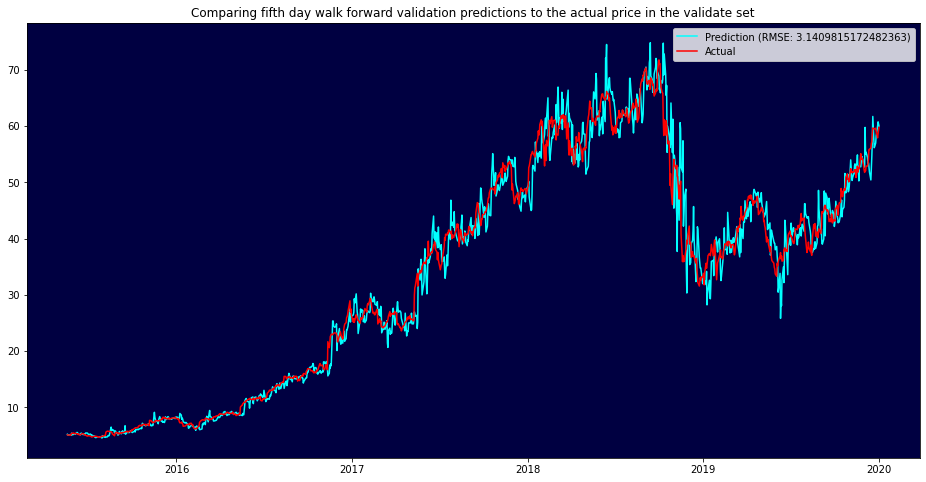

In [20]:
s, o, k = params
n = 5
end = len(validate)-n
preds = list()
for i in range(end):
    data = pd.concat([train, validate[:i]])
    pred = knn_ts(data, s, o, k, n)
    preds.append(pred["predictions"][n-1])

preds = pd.Series(preds, index=validate.index[n:])

rmse_pred = mean_squared_error(preds, validate[n:], squared=False)
fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor("#000041")
plt.plot(preds, color="cyan", label=f"Prediction (RMSE: {rmse_pred})")
plt.plot(validate[n:], color="red", label="Actual")
plt.legend()
plt.title(f"Comparing fifth day walk forward validation predictions to the actual price in the validate set")
plt.show()

From the plot above we can see that the kNN algorithm does a decent job at following the actual price when we forecast out to the fifth day. However, it appears to bounce around more drastically when there are fast swings in price.

## Conclusion

While it was fun to make this algorithm I do not think it performs well enough to accurately inform an options trading strategy alone. I will explore it's usefulness as part of an ensemble model later.